# Mongabay deforestation charts tool

This notebook explores the data for mongabay deforestation charts under the charts tool.
The main requirements are defined [here](https://docs.google.com/document/d/17U4nyDrYOw64ptzFe6IPMGyOX0UpgktmphFtIEGOcm4/edit#)

The data used on this exploration in based on a dirty dataset sourced [here](https://docs.google.com/spreadsheets/d/1KGb2Enin_EWTiZy7uHaCN_v6NEdddT77E9KemJh2ruI/edit#gid=301020640)

**Note about data processing requirements:**

The data came from different sources:
* Sensors:
    * Deter from INPE  
    * SAD from Imazon  
    * PRODES from INPE  
    * Forest loss from UMD - Matt Hansen 
* Locations:
    * Brazil administrative regions (Country and first level) 
    * Brazil Biomes

The data needs to be adapted to the next data model:  
| date | scenario  | timestep | location | driver | sensor | value | unit |
|------|-----------|----------|----------|--------|--------|-------|------|
|      |           |          |          |        |        |       |      |  


Depending on the sensor the data aquisition will variate: 
* From UMD and administrative levels we will need to use [gfw data api](https://data-api.globalforestwatch.org/dataset/gadm__tcl__iso_change/v20221012/query/json), for biomes we will need to calculate ourselves or make use of gfw areas of interest. 
* From deter and prodes that cames from INPE data will came from [terrabrasilis](http://terrabrasilis.dpi.inpe.br/) but we will need to check if the Locations are properly captured. If not we will need to perform such calculations from raw data
* SAD came from imazon https://imazongeo.org.br/#/
* Also there is an alternative source we could explore https://plataforma.alerta.mapbiomas.org/


## Metrics

Let's start by defining the metrics we will use to explore the data.  
* moving averages (MA)
* cumulative moving averages (CMA)
* exponential moving averages (EMA)
* moving average convergence/divergence (MACD)
* cumulative summation (CSUM)



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [37]:
sheet_id = "1KGb2Enin_EWTiZy7uHaCN_v6NEdddT77E9KemJh2ruI"
sheet_name = "data"
dtypes = {
    "scenario": "category",
    "timestep": "category",
    "location": "category",
    "driver": "category",
    "sensor": "category",
}
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
data = pd.read_csv(url, dtype=dtypes, parse_dates=["date"])
data["value"] = data["value"].str.replace(",", "").astype(float).round(4)
data.head()

,date,scenario,timestep,location,driver,sensor,value,unit
0,1988-01-01,deforestation,year,brazil,total,prodes,21050.0,sqkm
1,1989-01-01,deforestation,year,brazil,total,prodes,17770.0,sqkm
2,1990-01-01,deforestation,year,brazil,total,prodes,13730.0,sqkm
3,1991-01-01,deforestation,year,brazil,total,prodes,11030.0,sqkm
4,1992-01-01,deforestation,year,brazil,total,prodes,13786.0,sqkm


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      455 non-null    datetime64[ns]
 1   scenario  455 non-null    category      
 2   timestep  455 non-null    category      
 3   location  455 non-null    category      
 4   driver    455 non-null    category      
 5   sensor    455 non-null    category      
 6   value     454 non-null    float64       
 7   unit      455 non-null    object        
dtypes: category(5), datetime64[ns](1), float64(1), object(1)
memory usage: 13.4+ KB


# Deforestation data

In [102]:
data_pivot = (
    data[(data["timestep"] == "year") & (data["location"] == "brazil")]
    .pivot(index="date", columns="sensor", values="value")
    .dropna()
)
data_pivot["umd_forest_loss"] = data_pivot["umd_forest_loss"] * 0.01  # ha to km2
data_pivot.head()

sensor,prodes,umd_forest_loss
date,,
2001-01-01,18165.0,27463.61557
2002-01-01,21651.0,35070.49440
2003-01-01,25396.0,32485.26734
2004-01-01,27772.0,38487.70790
2005-01-01,19014.0,34865.62705


<AxesSubplot: xlabel='date'>

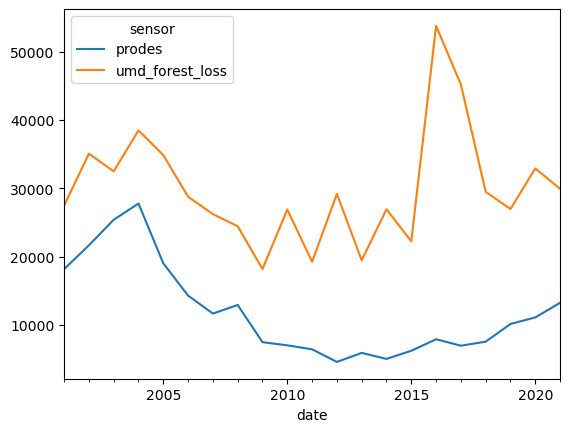

In [103]:
data_pivot.plot()

<AxesSubplot: xlabel='date'>

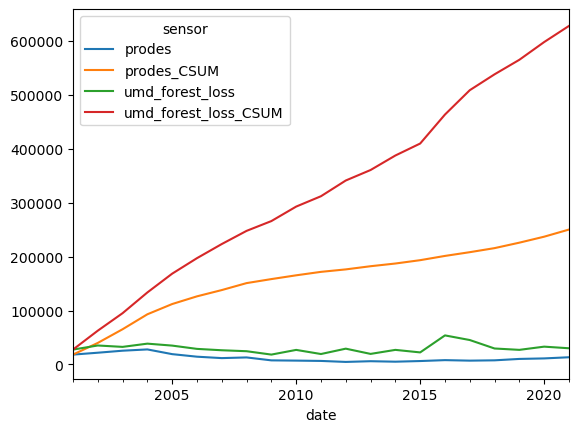

In [106]:
data_pivot["prodes_CSUM"] = data_pivot["prodes"].cumsum()
data_pivot["umd_forest_loss_CSUM"] = data_pivot["umd_forest_loss"].cumsum()
data_pivot[["prodes", "prodes_CSUM", "umd_forest_loss", "umd_forest_loss_CSUM"]].plot()

# Alerts

In [84]:
data_pivot = data[
    (data["timestep"] == "monthly") & (data["location"] == "brazil")
].pivot(index="date", columns="sensor", values="value")

data_pivot["deter_merge"] = data_pivot[["deter", "deter-b"]].bfill(axis=1).iloc[:, 0]
data_pivot.head()

sensor,deter,deter-b,sad,deter_merge
date,,,,
2007-04-01,64.45,NaN,106.0,64.45
2007-05-01,1222.33,NaN,398.0,1222.33
2007-06-01,1398.17,NaN,499.0,1398.17
2007-07-01,1025.38,NaN,961.0,1025.38
2007-08-01,190.93,NaN,663.0,190.93


<AxesSubplot: xlabel='date'>

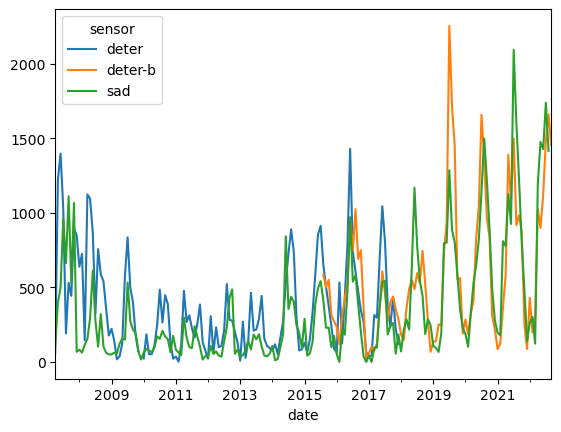

In [89]:
data_pivot[["deter", "deter-b", "sad"]].plot()

### Moving averages

<AxesSubplot: xlabel='date'>

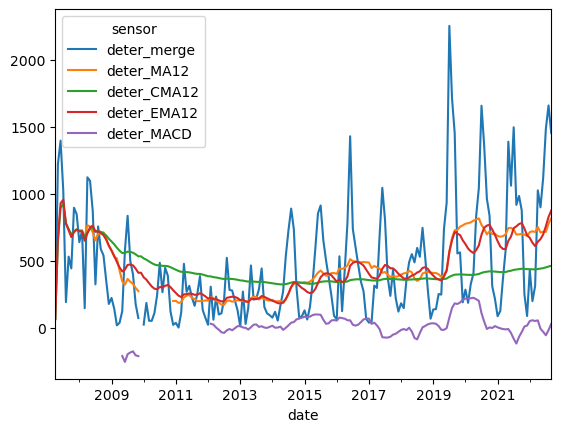

In [98]:
data_pivot["deter_CMA12"] = data_pivot["deter_merge"].expanding().mean()
data_pivot["deter_EMA12"] = data_pivot["deter_merge"].ewm(12).mean()
data_pivot["deter_MA12"] = data_pivot["deter_merge"].rolling(12).mean()
data_pivot["deter_MACD"] = (
    data_pivot["deter_merge"].rolling(12).mean()
    - data_pivot["deter_merge"].rolling(26).mean()
)
data_pivot[
    ["deter_merge", "deter_MA12", "deter_CMA12", "deter_EMA12", "deter_MACD"]
].plot()

<AxesSubplot: xlabel='date'>

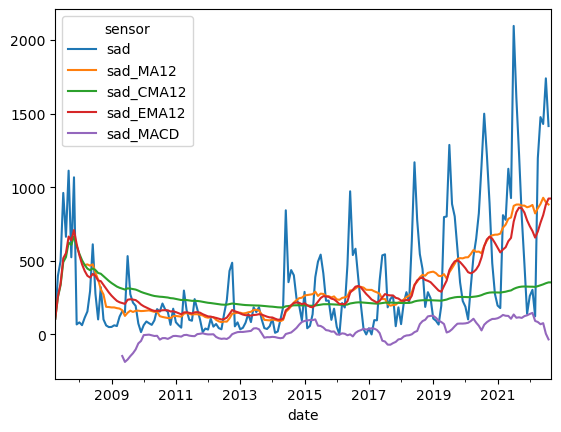

In [99]:
data_pivot["sad_CMA12"] = data_pivot["sad"].expanding().mean()
data_pivot["sad_EMA12"] = data_pivot["sad"].ewm(12).mean()
data_pivot["sad_MA12"] = data_pivot["sad"].rolling(12).mean()
data_pivot["sad_MACD"] = (
    data_pivot["sad"].rolling(12).mean() - data_pivot["sad"].rolling(26).mean()
)

data_pivot[["sad", "sad_MA12", "sad_CMA12", "sad_EMA12", "sad_MACD"]].plot()

<AxesSubplot: xlabel='date'>

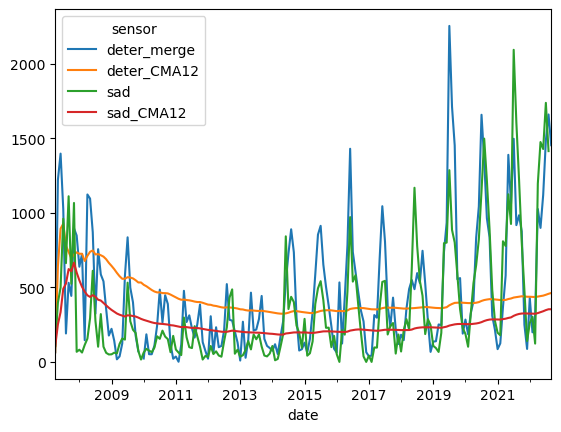

In [93]:
data_pivot[["deter_merge", "deter_CMA12", "sad", "sad_CMA12"]].plot()

<AxesSubplot: xlabel='date'>

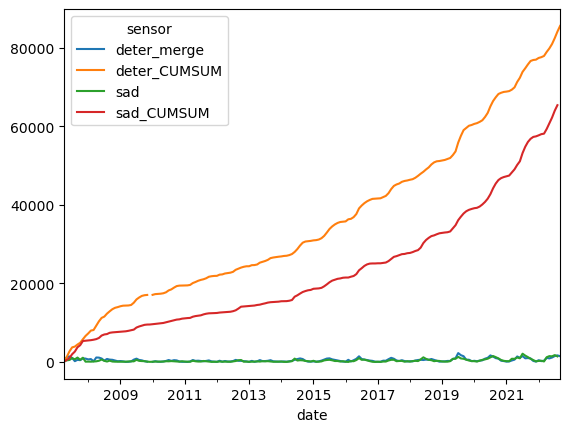

In [100]:
data_pivot["deter_CSUM"] = data_pivot["deter_merge"].cumsum()
data_pivot["sad_CSUM"] = data_pivot["sad"].cumsum()
data_pivot[["deter_merge", "deter_CSUM", "sad", "sad_CSUM"]].plot()